# DATA20001 Deep Learning - Group Project
## Text project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to news articles.  The corpus contains ~850K articles from Reuters.  The test set is about 10% of the articles. The data is unextracted in XML files.

We're only giving you the code for downloading the data, and how to save the final model. The rest you'll have to do yourselves.

Some comments and hints particular to the project:

- One document may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are documents that don't belong to any class, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.
- You may use word-embeddings to get better results. For example, you were already using a smaller version of the GloVE  embeddings in exercise 4. Do note that these embeddings take a lot of memory. 
- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [2]:
import sys
import os
from os.path import exists
import zipfile
import gc
import pickle

# text handling
from bs4 import BeautifulSoup as bs
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# dataframes
import pandas as pd
import numpy as np

# visualization
import seaborn as sns

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision.datasets.utils import download_url


#TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sklearn & matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
#%matplotlib inline

# wheel
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'


import ast

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the data

In [ ]:
root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [ ]:
print(os.getcwd())

In [ ]:
train_path = 'train'
dl_file = 'reuters-training-corpus.zip'

with zipfile.ZipFile(dl_file) as zip_f:
  zip_f.extractall(train_path)

In [ ]:
def extract_main_corpus(main_file_path, destination_file_path):
  with zipfile.ZipFile(main_file_path) as zip_f:
    zip_f.extractall(destination_file_path)

In [ ]:
topic_codes_location = 'topic_codes.txt'
# from get_data.py
def get_codes(codefile):
    codes = {}
    i = 0
    with open(codefile, 'r') as cf:
        for line in cf:
            if not line.startswith(';'):
                code = line.strip().split('\t')[0]
                codes[code] = i
                i += 1
    return codes

CODEMAP = get_codes(topic_codes_location)
CODEMAP_list = (list(CODEMAP.keys()))

In [ ]:
print(len(CODEMAP_list))

126


In [ ]:
#train_path = os.path.abspath(os.path.join(root_dir, train_path))
train_path = 'train'
reuters_unzipped_path = os.path.abspath(os.path.join(train_path, 'REUTERS_CORPUS_2'))

zipped_news_files = os.listdir(os.path.abspath(reuters_unzipped_path))
print(len(zipped_news_files))
zipped_news_files = [x for x in zipped_news_files if "1" in x]
print(len(zipped_news_files))

130
127


In [ ]:
rows_list = []

In [ ]:
%%time


pattern = r'"([A-Za-z0-9_\./\\-]*)"'

for news_file in zipped_news_files:
    zf = zipfile.ZipFile(os.path.abspath(os.path.join(reuters_unzipped_path, news_file)), 'r')
    for name in zf.namelist():
        dict1 = {} # saving into dicts which are then saved into a list which is then saved into the df.
        f = zf.open(name).read()
        soup = bs(f, "lxml")
        
        #title = soup.title.text
        dict1["title"] = soup.title.text
        dict1["text"] = soup.find("text").text
        codes = []
        metadata_codes = soup.metadata.find_all("code")
        
        for val in metadata_codes:
            m = re.search(pattern, str(val))
            codes.append(m.group().replace('"', ''))
        
        dict1["codes"] = [value for value in codes if value in CODEMAP_list] # remove unnecessary codes
        
        rows_list.append(dict1)
    #break # remove break for full dataframe



CPU times: user 9min 16s, sys: 1.94 s, total: 9min 18s
Wall time: 12min 34s


Use this code to load dataset from text file. Text file is a list of dictionary(faster way to load data)

In [ ]:
df = pd.DataFrame(rows_list, columns=['title', 'text', 'codes'])
print('shape:', df.shape)

shape: (299773, 3)


In [ ]:
#Check out the dataframe
df.head()

,title,text,codes
0,JAPAN: Tokyo stocks likely to rise after Dow r...,\nTokyo stocks are likely to rise in Tuesday's...,"[M11, MCAT]"
1,EU: OFFICIAL JOURNAL CONTENTS - OJ C 111 OF A...,\n*\nCommon position (EC) No 11/97 of 20 Decem...,"[G15, GCAT]"
2,EU: OFFICIAL JOURNAL CONTENTS - OJ C 113 OF A...,\n*\nEcu (97/C 113/01)\nProposal for a Council...,"[G15, GCAT]"
3,EU: OFFICIAL JOURNAL CONTENTS - OJ C 114 OF A...,\n*\n(Note - contents are displayed in reverse...,"[G15, GCAT]"
4,EU: OFFICIAL JOURNAL CONTENTS - OJ L 97 OF AP...,\n*\n(Note - contents are displayed in reverse...,"[G15, GCAT]"


In [ ]:
#inspect the text content
df.loc[1]["text"]

'\n*\nCommon position (EC) No 11/97 of 20 December 1996 adopted by the Council, acting in accordance with the procedure referred to in Article 189b of the Treaty establishing the European Community, with a view to adopting a European Parliament and Council Directive amending Directives 92/50/EEC, 93/36/EEC and 93/37/EEC concerning the coordination of procedures for the award of public service contracts, public supply contracts and public works contracts respectively (97/C 111/01)\nCommon position (EC) No 12/97 of 20 December 1996 adopted by the Council, acting in accordance with the procedure referred to in Article 189b of the Treaty establishing the European Community, with a view to adopting a European Parliament and Council Directive amending Directive 93/38/EEC coordinating the procurement procedures of entities operating in the water, energy, transport and telecommunications sectors (97/C 111/02)\nCommon position (EC) No 13/97 of 27 January 1997 adopted by the Council, acting in a

In [ ]:
def display_Codes(df):
    codes = df["codes"].values  #Get the Codes from the dataframe
    
    #Convert the list of lists to a single list
    code_list= []
    for sublist in codes:
        for item in sublist:
            code_list.append(item)
            
    #Get unique codes from the list        
    code_list_unique = np.array(code_list)
    print("Unique number of codes: ", len(np.unique(code_list_unique)))
    
    
    #Count the frequency of codes in the list
    code_freq = nltk.FreqDist(code_list)
    
    code_freq_df = pd.DataFrame({'Code': list(code_freq.keys()), 
                              'Count': list(code_freq.values())})
    
    #Convert the count to a dataframe and plot codes with more than 50 counts
    g = code_freq_df.nlargest(columns="Count", n=50)
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=g, x= "Count", y = "Code") 
    ax.set(ylabel = 'Count') 
    plt.show()

Unique number of codes:  103


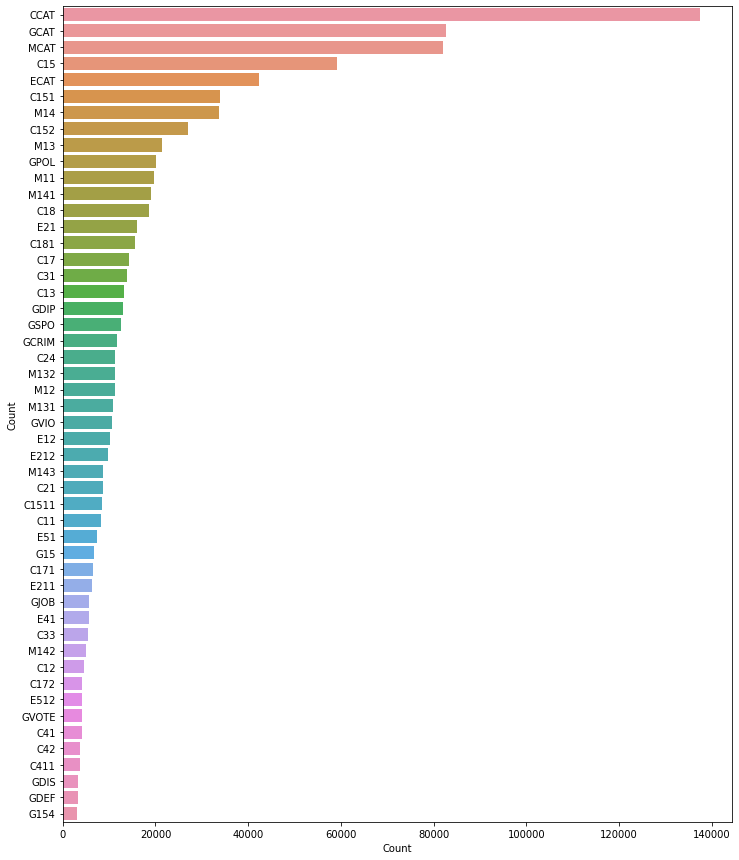

In [ ]:
display_Codes(df)

In [ ]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\n'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
lemmatizer = WordNetLemmatizer() 

def lemmatize(words):
    lemmatized_text = [lemmatizer.lemmatize(t, pos='n') for t in words] # lemmatized nouns
    return ''.join(lemmatized_text)

In [ ]:
def implement_clean_text(df):
    df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x))
    df['clean_text'] = df['clean_text'].apply(lambda x: lemmatize(x))
    return df

In [ ]:
df = implement_clean_text(df)

In [ ]:
#inspect column
df.iloc[0:5][['clean_text','codes']]

,clean_text,codes
0,tokyo stocks likely rise tuesday session follo...,"[M11, MCAT]"
1,common position ec december adopted council ac...,"[G15, GCAT]"
2,ecu c proposal council decision concerning com...,"[G15, GCAT]"
3,note contents displayed reverse order printed ...,"[G15, GCAT]"
4,note contents displayed reverse order printed ...,"[G15, GCAT]"


In [ ]:
df.tail()

,title,text,codes,clean_text
299768,CHINA: FUND VIEW-Thai baht batters Asia sentim...,\nThailand's flotation of the baht will darken...,"[M11, M13, M132, MCAT]",thailand flotation baht darken cloud hanging s...
299769,UK: LONDON CURRENCY AND GOLD BULLION RATES.,"\nLONDON, Reuter - Following are the buying an...","[M13, M132, M14, M142, MCAT]",london reuter following buying selling rates l...
299770,AUSTRALIA: L.Lease in equities deal with Capaial.,\nProperty and investment group Lend Lease Cor...,[C11],property investment group lend lease corp ltd ...
299771,NEW ZEALAND: NZ to host international young de...,\nNew Zealand is to host the inaugural interna...,"[GCAT, GSCI]",new zealand host inaugural international young...
299772,UK: Stoiber says EMU delay better than weak euro.,\nA delay in Europe's Economic and Monetary Un...,"[E12, G151, G154]",delay europe economic monetary union would bet...


In [ ]:
x_encoder_filename = 'X_encoder.pickle'
y_encoder_filename = 'Y_encoder.pickle'

In [ ]:
def create_encoder(data, input_column="clean_text", output_column="codes", X_encoder_filename = x_encoder_filename, Y_encoder_filename=y_encoder_filename):
    
    #initialize tokenizer
    tokenizer = Tokenizer()
    
    #Tokennize clean_text dataseries
    X_token = (data[input_column].astype("str"))
    tokenizer.fit_on_texts(X_token)
    
    #Initialize multilabelbinarizer for encoding codes in one hot
    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(data[output_column])
    
    #Save encoders to pickle
    with open(X_encoder_filename, 'wb') as handle:
        pickle.dump(tokenizer, handle)
    with open(Y_encoder_filename, 'wb') as handle:
        pickle.dump(multilabel_binarizer, handle)
    
    return tokenizer, multilabel_binarizer

In [ ]:
def tokenize_data(data,X_encoder, Y_encoder,input_column="clean_text", output_column="codes"):
    #Convert cleaned text dataseries to token
    X_raw= X_encoder.texts_to_sequences(df[input_column].astype("str"))
    #Pad text sequence to max of 1000 tokens. This was done so as most of the text had <1000 token
    X_raw= np.array(pad_sequences(X_raw, maxlen=1000, padding= 'post'))
    
    #transform code dataseries
    y_raw = Y_encoder.transform(data[output_column])
    
    return X_raw, y_raw

In [ ]:
def load_encoder(X_encoder_filename = x_encoder_filename, Y_encoder_filename=y_encoder_filename):
    with open (X_encoder_filename, 'rb') as handle:
        X_encoder = pickle.load(handle)
    
    with open(Y_encoder_filename, 'rb') as handle:
        Y_encoder = pickle.load(handle)
    
    return X_encoder, Y_encoder

In [ ]:
use_preexisting_x_encoder = False
use_preexisting_y_encoder = False

In [ ]:
if (use_preexisting_x_encoder and use_preexisting_y_encoder):
    x_encoder, y_encoder = load_encoder()
else:
    x_encoder, y_encoder = create_encoder(data=df)

In [ ]:
x_input, y_input = tokenize_data(df, x_encoder, y_encoder)

In [ ]:
y_input.shape[1]

126

In [ ]:
X_train,X_valid, y_train, y_valid = train_test_split(x_input, y_input, test_size=0.2) 

In [ ]:
x_input[0:6]

array([[ 619,  156,  219, ...,    0,    0,    0],
       [ 268,  548, 2584, ...,    0,    0,    0],
       [3237,  217,  849, ...,    0,    0,    0],
       [ 160, 6752, 7486, ...,    0,    0,    0],
       [ 160, 6752, 7486, ...,    0,    0,    0],
       [ 160, 6752, 7486, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_input[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
class createDataset(Dataset):
    def __init__(self, X,Y):
        self.X = X
        self.y=Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return  torch.from_numpy(self.X[idx]).long(), torch.from_numpy(self.y[idx]).long()

In [ ]:
train_ds = createDataset(X_train,y_train)
valid_ds= createDataset(X_valid,y_valid)

In [ ]:
train_loader = DataLoader(train_ds, batch_size = 32)
valid_loader = DataLoader(valid_ds, batch_size = 32)

In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1000]) type: torch.LongTensor
y_train: torch.Size([32, 103]) type: torch.LongTensor


In [ ]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


In [ ]:
class LSTM_Model_rnn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,output_size):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim,padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim,hidden_dim,bidirectional=True, batch_first=True)       
        self.l1 = torch.nn.Linear(hidden_dim , 250)
        self.l2 = torch.nn.Linear(250, output_size)


    
    def forward(self,x):
        embedded = self.embedding(x)
        _, (last_hidden,state) = self.rnn(embedded)
        hidden_list = last_hidden[-1]
        encoded2 = F.relu(self.l1(hidden_list))
        output = torch.sigmoid(self.l2(encoded2))
        return output

In [ ]:
total_words = len(x_encoder.word_index)+1

model_rnn = LSTM_Model_rnn(total_words,100,100,y_input.shape[1])
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
criterion_rnn = nn.MSELoss()

In [ ]:
print(model_rnn)

LSTM_Model_rnn(
  (embedding): Embedding(232385, 100, padding_idx=0)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (l1): Linear(in_features=100, out_features=250, bias=True)
  (l2): Linear(in_features=250, out_features=103, bias=True)
)


In [ ]:
def changedata(x):
    return 1*(x>0.5)

In [ ]:
model_rnn.to(device)

LSTM_Model_rnn(
  (embedding): Embedding(232385, 100, padding_idx=0)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (l1): Linear(in_features=100, out_features=250, bias=True)
  (l2): Linear(in_features=250, out_features=103, bias=True)
)

In [ ]:
def train_rnn(epoch,log_interval=100):

 
    model_rnn.train()
    for batch_idx, (data_rnn, target_rnn) in enumerate(train_loader):
          
        data_rnn= data_rnn.to(device)
        target_rnn = target_rnn.to(device)
        target_rnn= target_rnn.float()
        data_rnn = data_rnn.long()
        optimizer_rnn.zero_grad()
        output_rnn = model_rnn(data_rnn)
          
        loss = criterion_rnn(output_rnn, target_rnn)
          
        loss.backward()

        optimizer_rnn.step()     
        #break
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data_rnn), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
def validate_rnn(loss_vector, f1_score_vector, recall_score_vector, precision_score_vector):
    model_rnn.eval()

    val_loss, val_f1 = 0, 0
    recall_value, precision_value = 0,0
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        target= target.float()
        data = data.long()
        output = model_rnn(data)
        val_loss += criterion_rnn(output, target).data.item()
        output_val= np.array(changedata(output).cpu().detach())[0]
        target_val = np.array(changedata(target).cpu().detach())[0]
        val_f1  += f1_score(target_val,output_val, average='micro')
        recall_value += recall_score(target_val,output_val, average='micro')
        precision_value += precision_score(target_val,output_val, average='micro')
        
        
        
    val_loss /= len(valid_loader)
    loss_vector.append(val_loss)

    f1_score_val = val_f1 / len(valid_loader)
    f1_score_vector.append(f1_score_val)
    

    recal_score_value = recall_value /len(valid_loader)
    recall_score_vector.append(recal_score_value)

    precision_score_value = precision_value/len(valid_loader)
    precision_score_vector.append(precision_score_value)

    print('\nValidation set: Average loss: {:.4f}, Average F1 Score: {:.2f}, Average Recall Score: {:.2f}, Average Precision Score: {:.2f}\n'.format(val_loss,  f1_score_val, recal_score_value, precision_score_value))

In [ ]:
%%time
epochs = 3

lossv, accv, recall, precision = [], [], [], []
for epoch in range(1, epochs + 1):
    train_rnn(epoch)
    validate_rnn(lossv, accv, recall, precision)

Train Epoch: 1 [0/239818 (0.0%)]	Loss: 0.249940
Train Epoch: 1 [3200/239818 (1.3%)]	Loss: 0.028026
Train Epoch: 1 [6400/239818 (2.7%)]	Loss: 0.028829
Train Epoch: 1 [9600/239818 (4.0%)]	Loss: 0.028656
Train Epoch: 1 [12800/239818 (5.3%)]	Loss: 0.027366
Train Epoch: 1 [16000/239818 (6.7%)]	Loss: 0.026335
Train Epoch: 1 [19200/239818 (8.0%)]	Loss: 0.021342
Train Epoch: 1 [22400/239818 (9.3%)]	Loss: 0.021863
Train Epoch: 1 [25600/239818 (10.7%)]	Loss: 0.017605
Train Epoch: 1 [28800/239818 (12.0%)]	Loss: 0.017568
Train Epoch: 1 [32000/239818 (13.3%)]	Loss: 0.015858
Train Epoch: 1 [35200/239818 (14.7%)]	Loss: 0.020551
Train Epoch: 1 [38400/239818 (16.0%)]	Loss: 0.016861
Train Epoch: 1 [41600/239818 (17.3%)]	Loss: 0.011684
Train Epoch: 1 [44800/239818 (18.7%)]	Loss: 0.013906
Train Epoch: 1 [48000/239818 (20.0%)]	Loss: 0.014098
Train Epoch: 1 [51200/239818 (21.3%)]	Loss: 0.013368
Train Epoch: 1 [54400/239818 (22.7%)]	Loss: 0.013227
Train Epoch: 1 [57600/239818 (24.0%)]	Loss: 0.010808
Train Ep

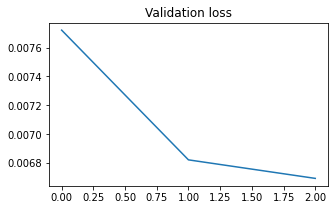

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(epochs), lossv)
plt.title('Validation loss')
plt.show();

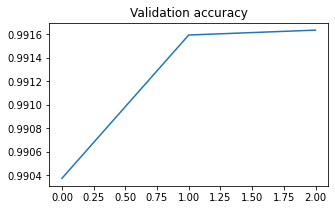

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(epochs), accv)
plt.title('Validation accuracy')
plt.show();

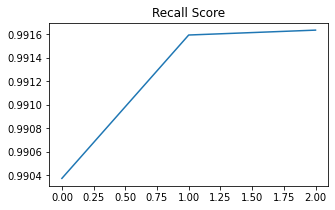

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(epochs), recall)
plt.title('Recall Score')
plt.show();

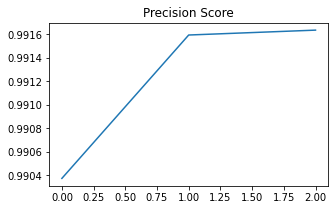

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(epochs), precision)
plt.title('Precision Score')
plt.show();

# **Train the whole dataset**

In [ ]:
x_input, y_input = tokenize_data(df, x_encoder, y_encoder)

In [ ]:
train_ds = createDataset(x_input,y_input)

In [ ]:
train_loader = DataLoader(train_ds, batch_size = 32)

In [ ]:
total_words = len(x_encoder.word_index)+1

model_rnn = LSTM_Model_rnn(total_words,100,100,y_input.shape[1])
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
criterion_rnn = nn.MSELoss()

In [ ]:
model_rnn.to(device)

LSTM_Model_rnn(
  (embedding): Embedding(232385, 100, padding_idx=0)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (l1): Linear(in_features=100, out_features=250, bias=True)
  (l2): Linear(in_features=250, out_features=103, bias=True)
)

In [ ]:
%%time
epochs = 3


for epoch in range(1, epochs + 1):
    train_rnn(epoch)

Train Epoch: 1 [0/299773 (0.0%)]	Loss: 0.250106
Train Epoch: 1 [3200/299773 (1.1%)]	Loss: 0.034272
Train Epoch: 1 [6400/299773 (2.1%)]	Loss: 0.024281
Train Epoch: 1 [9600/299773 (3.2%)]	Loss: 0.023901
Train Epoch: 1 [12800/299773 (4.3%)]	Loss: 0.029998
Train Epoch: 1 [16000/299773 (5.3%)]	Loss: 0.024854
Train Epoch: 1 [19200/299773 (6.4%)]	Loss: 0.018665
Train Epoch: 1 [22400/299773 (7.5%)]	Loss: 0.023542
Train Epoch: 1 [25600/299773 (8.5%)]	Loss: 0.023106
Train Epoch: 1 [28800/299773 (9.6%)]	Loss: 0.017971
Train Epoch: 1 [32000/299773 (10.7%)]	Loss: 0.020844
Train Epoch: 1 [35200/299773 (11.7%)]	Loss: 0.012264
Train Epoch: 1 [38400/299773 (12.8%)]	Loss: 0.019662
Train Epoch: 1 [41600/299773 (13.9%)]	Loss: 0.022064
Train Epoch: 1 [44800/299773 (14.9%)]	Loss: 0.015677
Train Epoch: 1 [48000/299773 (16.0%)]	Loss: 0.009791
Train Epoch: 1 [51200/299773 (17.1%)]	Loss: 0.012374
Train Epoch: 1 [54400/299773 (18.1%)]	Loss: 0.010609
Train Epoch: 1 [57600/299773 (19.2%)]	Loss: 0.002495
Train Epoc

In [ ]:
data = torch.from_numpy(X_valid[112].reshape(1,1000)).long().to(device)

In [ ]:
output = model_rnn(data)

In [ ]:
f1_score(y_valid[112],np.array(changedata(output).cpu().detach())[0], average='micro')

0.9902912621359223

In [ ]:
recall_score(y_valid[112],np.array(changedata(output).cpu().detach())[0], average='micro')

0.9902912621359223

In [ ]:
precision_score(y_valid[112],np.array(changedata(output).cpu().detach())[0], average='micro')

0.9902912621359223

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [ ]:
torch.save(model_rnn.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You will be asked to return your predictions a separate test set.  These should be returned as a matrix with one row for each test article.  Each row contains a binary prediction for each label, 1 if it's present in the image, and 0 if not. The order of the labels is the order of the label (topic) codes.

An example row could like like this if your system predicts the presense of the second and fourth topic:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0 ...
    
If you have the matrix prepared in `y` you can use the following function to save it to a text file.

In [ ]:
model_run = LSTM_Model_rnn(total_words,100,100,y_input.shape[1])

In [ ]:
model_rnn.load_state_dict(torch.load('model.pkl'))
model_rnn.eval()
model_rnn.to(device)

LSTM_Model_rnn(
  (embedding): Embedding(232385, 100, padding_idx=0)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (l1): Linear(in_features=100, out_features=250, bias=True)
  (l2): Linear(in_features=250, out_features=103, bias=True)
)

np.savetxt('results.txt', y, fmt='%d')

In [ ]:
test_file_path = 'text-test-corpus-N8C3E5U9.zip'
destination_file_path = 'test'

extract_main_corpus(test_file_path, destination_file_path)

In [ ]:
test_path = 'test'
text_test_path = os.path.abspath(os.path.join(test_path, 'text-test-corpus-STRIPPED'))

zipped_test_files = os.listdir(os.path.abspath(text_test_path))
print(len(zipped_test_files))
zipped_test_files = [x for x in zipped_test_files if "1" in x]
print(len(zipped_test_files))

15
14


In [ ]:
test_row_list= []

In [ ]:
%%time


pattern = r'"([A-Za-z0-9_\./\\-]*)"'

for news_file in zipped_test_files:
    zf = zipfile.ZipFile(os.path.abspath(os.path.join(text_test_path, news_file)), 'r')
    for name in zf.namelist():
        dict1 = {} # saving into dicts which are then saved into a list which is then saved into the df.
        f = zf.open(name).read()
        soup = bs(f, "lxml")
        
        #title = soup.title.text
        dict1["title"] = soup.title.text
        dict1["text"] = soup.find("text").text
        
        test_row_list.append(dict1)
    #break # remove break for full dataframe

CPU times: user 35.2 s, sys: 175 ms, total: 35.4 s
Wall time: 35.4 s


In [ ]:
df_test = pd.DataFrame(test_row_list, columns=['title', 'text'])
print('shape:', df_test.shape)

shape: (33142, 2)


In [ ]:
df_test.head()

,title,text
0,SOUTH AFRICA: PRESS DIGEST - SOUTH AFRICA - AP...,\nThese are the leading stories in the South A...
1,EU: OFFICIAL JOURNAL CONTENTS - OJ C 110 OF A...,\n*\n(Note - contents are displayed in reverse...
2,EU: OFFICIAL JOURNAL CONTENTS - OJ L 94 OF AP...,\n*\n(Note - contents are displayed in reverse...
3,EU: OFFICIAL JOURNAL CONTENTS - OJ C 55 OF FE...,"\n*\nMinutes of the sitting of Wednesday, 29 J..."
4,CANADA: Toronto stocks close easier in lacklus...,\nCHANGE\t\t\t\t CHANGE\nTSE\t 5790.11 ...


In [ ]:
df_test = implement_clean_text(df_test)

In [ ]:
df_test.head()

,title,text,clean_text
0,SOUTH AFRICA: PRESS DIGEST - SOUTH AFRICA - AP...,\nThese are the leading stories in the South A...,leading stories south african press thursday r...
1,EU: OFFICIAL JOURNAL CONTENTS - OJ C 110 OF A...,\n*\n(Note - contents are displayed in reverse...,note contents displayed reverse order printed ...
2,EU: OFFICIAL JOURNAL CONTENTS - OJ L 94 OF AP...,\n*\n(Note - contents are displayed in reverse...,note contents displayed reverse order printed ...
3,EU: OFFICIAL JOURNAL CONTENTS - OJ C 55 OF FE...,"\n*\nMinutes of the sitting of Wednesday, 29 J...",minutes sitting wednesday january thursday jan...
4,CANADA: Toronto stocks close easier in lacklus...,\nCHANGE\t\t\t\t CHANGE\nTSE\t 5790.11 ...,change change tse hi lo dji gold london us fts...


In [ ]:
class create_test_Dataset(Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return  torch.from_numpy(self.X[idx]).long()

In [ ]:
x_input_test, y_input_test = tokenize_data(df_test, x_encoder)

In [ ]:
test_dataset=create_test_Dataset(x_input_test)

In [ ]:
y_pred =[]
for i, data in enumerate(test_dataset):

  data= data.to(device)
  result_output = model_rnn(data.reshape(1,1000))
  y_pred.append(np.array(changedata(result_output).cpu().detach())[0])

In [ ]:
np.savetxt('results.txt', y_pred, fmt='%d')